# Amazon Fine Food Reviews

Model building for prediction and evaluation

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

In [2]:
## Import data
df = pd.read_csv("CleanedText.csv")
df.head()

,Review_type,text,cleanedtext
0,1,Good Quality Dog Food I have bought several ...,good quality dog food buy several vitality can...
1,1,Healthy Dog Food This is a very healthy dog ...,healthy dog food healthy dog food good digesti...
2,0,Bad I fed this to my Golden Retriever and he...,bad feed golden retriever hat eat give terribl...
3,0,"Not hot, not habanero I have to admit, I was...",hot habanero admit sucker large quantity oz sh...
4,1,The best weve tried so far We have a 7 week ...,best weve try far week old gas constipation pr...


## Word 2 vec model

In [3]:
df['tokenized_reviews'] = df['cleanedtext'].apply(lambda sent: str(sent).split())
df.head()

,Review_type,text,cleanedtext,tokenized_reviews
0,1,Good Quality Dog Food I have bought several ...,good quality dog food buy several vitality can...,"[good, quality, dog, food, buy, several, vital..."
1,1,Healthy Dog Food This is a very healthy dog ...,healthy dog food healthy dog food good digesti...,"[healthy, dog, food, healthy, dog, food, good,..."
2,0,Bad I fed this to my Golden Retriever and he...,bad feed golden retriever hat eat give terribl...,"[bad, feed, golden, retriever, hat, eat, give,..."
3,0,"Not hot, not habanero I have to admit, I was...",hot habanero admit sucker large quantity oz sh...,"[hot, habanero, admit, sucker, large, quantity..."
4,1,The best weve tried so far We have a 7 week ...,best weve try far week old gas constipation pr...,"[best, weve, try, far, week, old, gas, constip..."


In [4]:
model_w2v = Word2Vec(list(df.tokenized_reviews), vector_size=300, window=10,
                    min_count=1,workers=8)

In [5]:
print(model_w2v)

Word2Vec<vocab=103764, vector_size=300, alpha=0.025>


In [6]:
model_w2v.wv.__getitem__(model_w2v.wv.index_to_key).shape

(103764, 300)

In [7]:
pickle.dump(model_w2v,open("w2v_model.pkl","wb"))

In [8]:
# creating vector for each review by averaging word vectors
def sent_vector(sent):
    sent = [word for word in sent if word in model_w2v.wv.index_to_key]
    sent_vec = np.mean(model_w2v.wv.__getitem__(sent), axis=0)
    return sent_vec

In [8]:
df['review_vector'] = df['tokenized_reviews'].apply(sent_vector)

In [9]:
df.head()

,Review_type,text,cleanedtext,tokenized_reviews,review_vector
0,1,Good Quality Dog Food I have bought several ...,good quality dog food buy several vitality can...,"[good, quality, dog, food, buy, several, vital...","[-0.015360779, -0.24356443, 0.45380333, 0.4255..."
1,1,Healthy Dog Food This is a very healthy dog ...,healthy dog food healthy dog food good digesti...,"[healthy, dog, food, healthy, dog, food, good,...","[0.18326958, -0.64162564, 0.37955987, 0.576207..."
2,0,Bad I fed this to my Golden Retriever and he...,bad feed golden retriever hat eat give terribl...,"[bad, feed, golden, retriever, hat, eat, give,...","[0.035870653, -0.57822657, 0.2539622, 0.818605..."
3,0,"Not hot, not habanero I have to admit, I was...",hot habanero admit sucker large quantity oz sh...,"[hot, habanero, admit, sucker, large, quantity...","[0.5397752, 0.015083934, -0.32287642, -0.15726..."
4,1,The best weve tried so far We have a 7 week ...,best weve try far week old gas constipation pr...,"[best, weve, try, far, week, old, gas, constip...","[0.14418781, -0.28286204, -0.062710874, 0.3410..."


## Train Test split

In [10]:
X = df['review_vector']
y = df['Review_type']

In [11]:
# train test split
xtrain,xtest, ytrain,ytest = train_test_split(X,y, test_size=0.2,
                                             random_state=42, stratify=y)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((314856,), (78714,), (314856,), (78714,))

In [12]:
xtrain_v= list(xtrain)
xtest_v= list(xtest)

## Training Model

In [13]:
def model_eval(model,xtrain=xtrain_v,xtest=xtest_v,ytrain=ytrain, ytest=ytest):
  '''
  This function will take model and datasets as argument 
  and return accuracy score, classification report 
  '''
  # Fit modelon train set
  model.fit(xtrain,ytrain)
  # prediction on train set
  train_pred = model.predict(xtrain)

  # prediction on test set
  test_pred = model.predict(xtest)

  # accuracy score on test set
  acc_score = metrics.accuracy_score(y_true=ytest, y_pred=test_pred)

  # classification report on both train and test set
  
  print("Classification report on train set")
  print('\n')
  print(metrics.classification_report(y_true=ytrain, y_pred = train_pred ))
  print("_*_"*20)
  print("\n")
  print("Classification report on test set")
  print("\n")
  print(metrics.classification_report(y_true=ytest, y_pred = test_pred))
  

    # Confusion matrix
  metrics.ConfusionMatrixDisplay.from_predictions(y_true=ytest,
                                                  y_pred=test_pred)
    
    # Display ROC curve
  metrics.RocCurveDisplay.from_predictions(y_true=ytest,
                                            y_pred=test_pred)

    # return accuracy score
  return acc_score

### Random forest classifier

In [14]:
rf_classifier = RandomForestClassifier(n_estimators=150,n_jobs=-1)

Classification report on train set


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69421
           1       1.00      1.00      1.00    245435

    accuracy                           1.00    314856
   macro avg       1.00      1.00      1.00    314856
weighted avg       1.00      1.00      1.00    314856

_*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*_


Classification report on test set


              precision    recall  f1-score   support

           0       0.82      0.49      0.62     17355
           1       0.87      0.97      0.92     61359

    accuracy                           0.87     78714
   macro avg       0.85      0.73      0.77     78714
weighted avg       0.86      0.87      0.85     78714



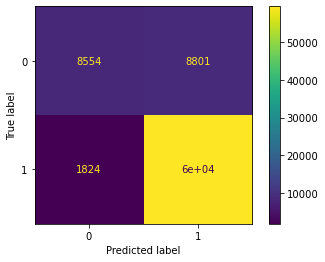

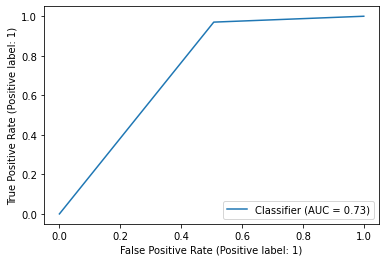

In [15]:
base_rf_acc = model_eval(rf_classifier)

### Dealing with imbalanced data

In [16]:
y.value_counts(normalize=True)

1    0.779516
0    0.220484
Name: Review_type, dtype: float64

In [17]:
y.value_counts()

1    306794
0     86776
Name: Review_type, dtype: int64

In [18]:
ratio = 306794/86776
print(int(ratio))

3


In [19]:
# instantiate inverse weights
weights = {1:1.0,0:3.0}

#### Random forest classifier with inverse weights

In [23]:
rf_weight_classifier = RandomForestClassifier(n_estimators=100,class_weight=weights)

Classification report on train set


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69421
           1       1.00      1.00      1.00    245435

    accuracy                           1.00    314856
   macro avg       1.00      1.00      1.00    314856
weighted avg       1.00      1.00      1.00    314856

_*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*_


Classification report on test set


              precision    recall  f1-score   support

           0       0.82      0.42      0.56     17355
           1       0.86      0.97      0.91     61359

    accuracy                           0.85     78714
   macro avg       0.84      0.70      0.73     78714
weighted avg       0.85      0.85      0.83     78714



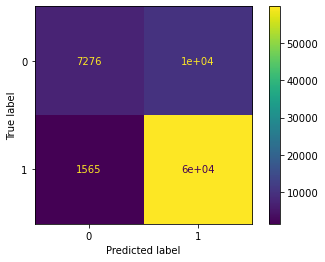

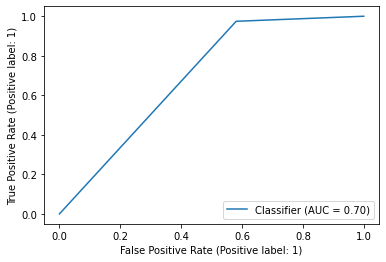

In [24]:
rf_weight_acc = model_eval(rf_weight_classifier)

### XGBoost classifier

As we have seen, Inverse weights are not working well with our data
We will use different algorithm with original weights 

C:\Users\arkur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:02:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report on train set


              precision    recall  f1-score   support

           0       0.86      0.74      0.80     69421
           1       0.93      0.97      0.95    245435

    accuracy                           0.92    314856
   macro avg       0.90      0.86      0.87    314856
weighted avg       0.92      0.92      0.92    314856

_*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*__*_


Classification report on test set


              precision    recall  f1-score   support

           0       0.78      0.66      0.71     17355
           1       0.91      0.95      0.93     61359

    accuracy                           0.88     78714
   macro 

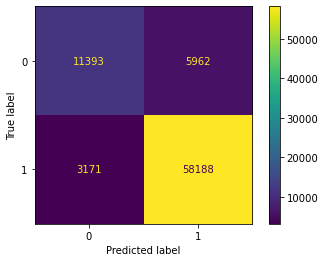

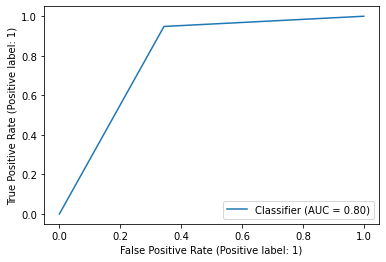

In [22]:
xgb_classifier = XGBClassifier(use_label_encoder=False)

xgb_classifier_acc = model_eval(xgb_classifier)

### XGboost classifier hyperparameter tuning

In [25]:
param = [{'n_estimators':[100,200,300],
          'learning_rate':[0.1,0.2]}]

In [26]:
g_search =GridSearchCV(XGBClassifier(use_label_encoder=False),
                      param, cv=5)

In [27]:
g_search.fit(xtrain_v,ytrain)

[18:41:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [28]:
print(g_search.best_estimator_)
print(g_search.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
{'learning_rate': 0.2, 'n_estimators': 300}


In [29]:
# xg boost classifier with hyperparametr tuning
xgb_hyp_clf = XGBClassifier(use_label_encoders=False,n_jobs=12,
                           n_estimators= 300, learning_rate=0.2)

C:\Users\arkur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:37:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "use_label_encoders" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:37:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report on train set


              precision    recall  f1-score   support

           0       0.92      0.82      0.86     69421
           1       0.95      0.98      0.96    245435

    accuracy                           0.94    314856
   macro

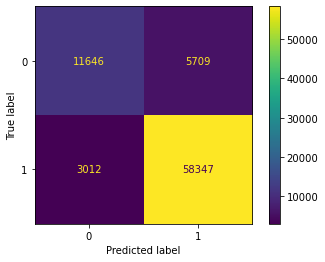

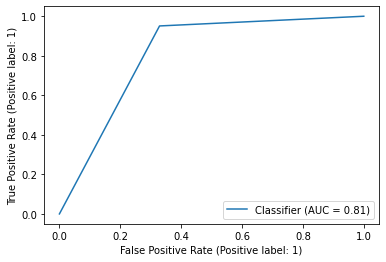

In [35]:
xgb_hyp_acc =model_eval(xgb_hyp_clf)

In [6]:
# savingf the model
import pickle

In [37]:
pickle.dump(xgb_hyp_clf,open("xgboost_model_hyp.pkl",'wb'))